# Fischers Linear Discriminant Analysis

In [1]:
# Importing required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib notebook

## Reading the dataset

In [2]:
df = pd.read_csv('dataset_FLD.csv', header=None)
num_data, num_columns = df.shape
num_features = num_columns - 1
head = [f'feature {i}' for i in range(1, num_columns)] + ['Class']
df.columns = head
df

,feature 1,feature 2,feature 3,Class
0,-6.672418,-1.206198,-1.081050,0
1,1.675598,0.614994,-0.971600,0
2,-4.039058,0.335102,0.544618,1
3,0.793526,-0.235277,0.551771,1
4,3.820273,-0.274691,0.454743,1
...,...,...,...,...
995,-3.680139,0.966962,-0.904337,0
996,-4.063900,0.802611,1.023708,1
997,-0.814430,-0.693945,0.876776,1
998,-0.325122,-0.759024,1.299772,1


## Generating Features and Class array

In [3]:
positive_mask = (df['Class'] == 1)
pos_points = df[positive_mask]
neg_points = df[~positive_mask]
num_pos = pos_points.shape[0]
num_neg = neg_points.shape[0]
print(pos_points)

     feature 1  feature 2  feature 3  Class
2    -4.039058   0.335102   0.544618      1
3     0.793526  -0.235277   0.551771      1
4     3.820273  -0.274691   0.454743      1
7     3.033109  -1.313129   1.392083      1
9     0.312040   0.009861   1.174191      1
..         ...        ...        ...    ...
992   0.662155  -0.542992   1.146189      1
993   0.385453   0.392990   0.535019      1
996  -4.063900   0.802611   1.023708      1
997  -0.814430  -0.693945   0.876776      1
998  -0.325122  -0.759024   1.299772      1

[500 rows x 4 columns]


## Visualizing the dataset

<IPython.core.display.Javascript object>


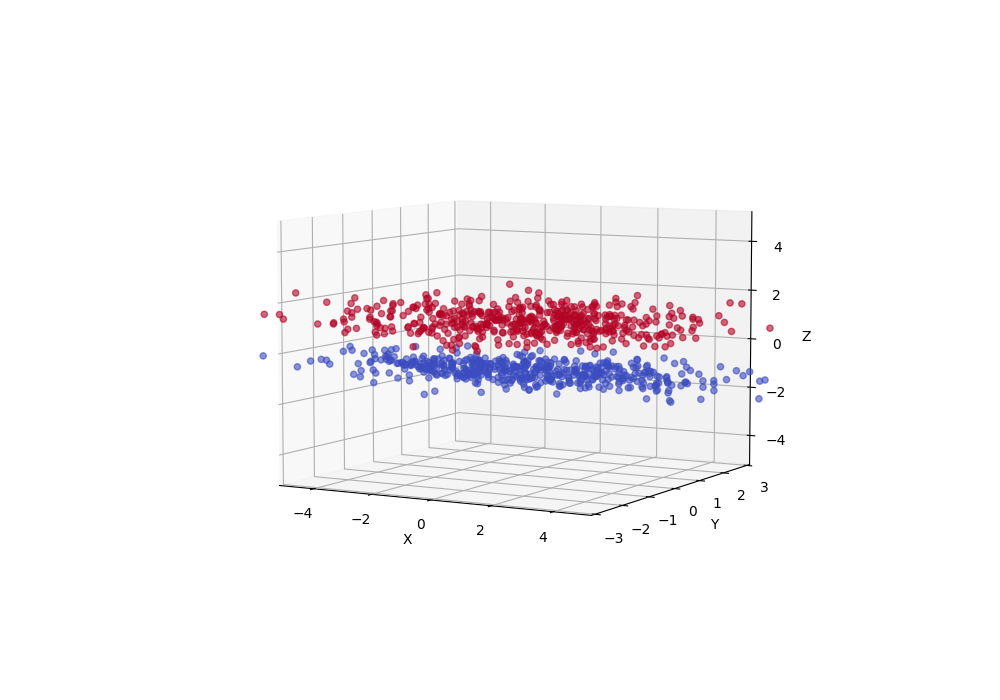

In [4]:
x = df.iloc[:, 0]
y = df.iloc[:, 1]
z = df.iloc[:, 2]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c=df.iloc[:,-1], cmap='coolwarm', alpha= 0.6)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_xlim(-5,5)
ax.set_ylim(-3,3)
ax.set_zlim(-5,5);

## Starting LDA

In [5]:
pos_mean = pos_points.mean().to_numpy().reshape((1, -1))[:, :-1]
neg_mean = neg_points.mean().to_numpy().reshape((1, -1))[:, :-1]
pos_mean

array([[0.22310309, 0.00255859, 1.01027072]])

In [6]:
pos_points = pos_points.drop(['Class'], axis=1)
neg_points = neg_points.drop(['Class'], axis=1)
pos_diff = pos_points - pos_mean
neg_diff = neg_points - neg_mean

In [7]:
pos_diff = pos_diff.to_numpy()
neg_diff = neg_diff.to_numpy()

### Getting Covariance Matrix

In [8]:
pos_sum = np.zeros((num_features, num_features))
neg_sum = np.zeros((num_features, num_features))

for x in pos_diff:
    x = x.reshape((1, -1))
    pos_sum += np.matmul(x.T, x)
for x in neg_diff:
    x = x.reshape((1, -1))
    neg_sum += np.matmul(x.T, x)

cov_matrix = pos_sum / num_pos + neg_sum / num_neg
cov_matrix

array([[18.12275486, -0.19720153,  0.1259276 ],
       [-0.19720153,  1.97240312,  0.02577773],
       [ 0.1259276 ,  0.02577773,  0.17936747]])

### Getting Weight Array

In [9]:
w = np.matmul(np.linalg.inv(cov_matrix), (pos_mean - neg_mean).T)
w = w / np.linalg.norm(w)
w

array([[-0.00655686],
       [-0.01823739],
       [ 0.99981218]])

In [10]:
# Finding projection of classes
project_pos = np.dot(pos_points.to_numpy(), w.flatten())
project_neg = np.dot(neg_points.to_numpy(), w.flatten())
print(project_pos.shape)

(500,)


### Function to find intersection of two normal curves

In [11]:
def solve(m1,m2,std1,std2):
    a = 1/(2*std1**2) - 1/(2*std2**2)
    b = m2/(std2**2) - m1/(std1**2)
    c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
    return np.roots([a,b,c])

### Finding the Intersection

In [12]:
positive_mean = project_pos.mean()
negative_mean = project_neg.mean()
positive_std = project_pos.std()
negative_std = project_neg.std()

result = solve(positive_mean, negative_mean, positive_std, negative_std)
result = result[1]

### Visualizing the results

<IPython.core.display.Javascript object>


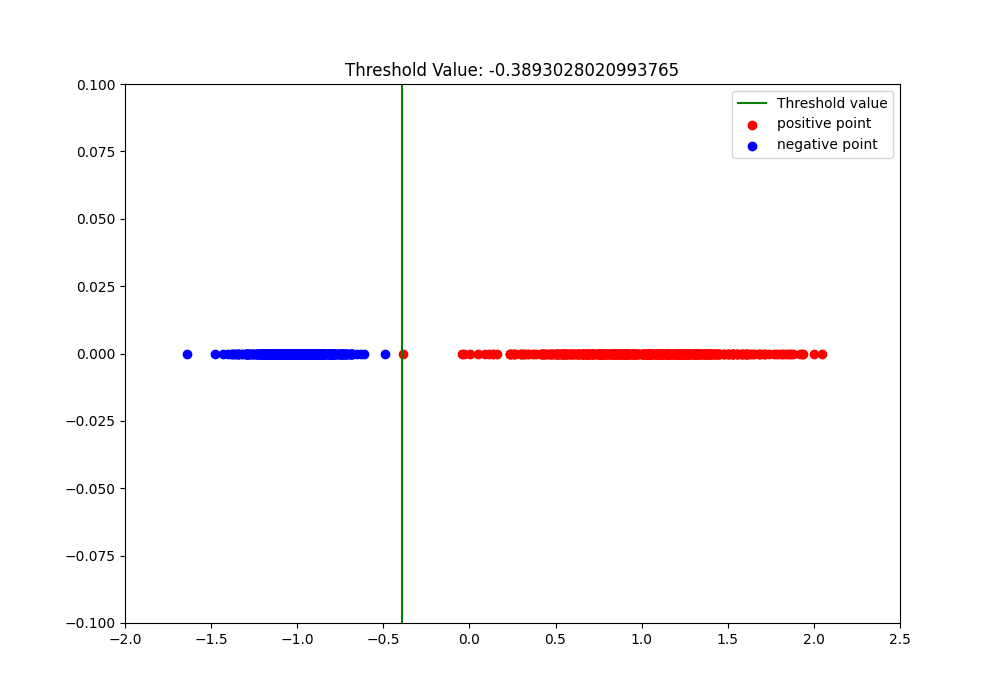

In [13]:
arrp = np.zeros((len(project_pos)))
arrn = np.zeros((len(project_neg)))

plt.figure(figsize = (10,7))
plt.title(f'Threshold Value: {result}')
plt.scatter(project_pos, arrp, color = 'red', label = 'positive point')
plt.scatter(project_neg, arrn, color = 'blue', label = 'negative point')
yp = np.linspace(-0.1, 0.1, 1000)
xp = result * np.ones((1000))
plt.plot(xp, yp*1000, color = 'green', label = 'Threshold value')
plt.ylim(-0.1, 0.1)
plt.xlim(-2, 2.5)
plt.legend();

<IPython.core.display.Javascript object>


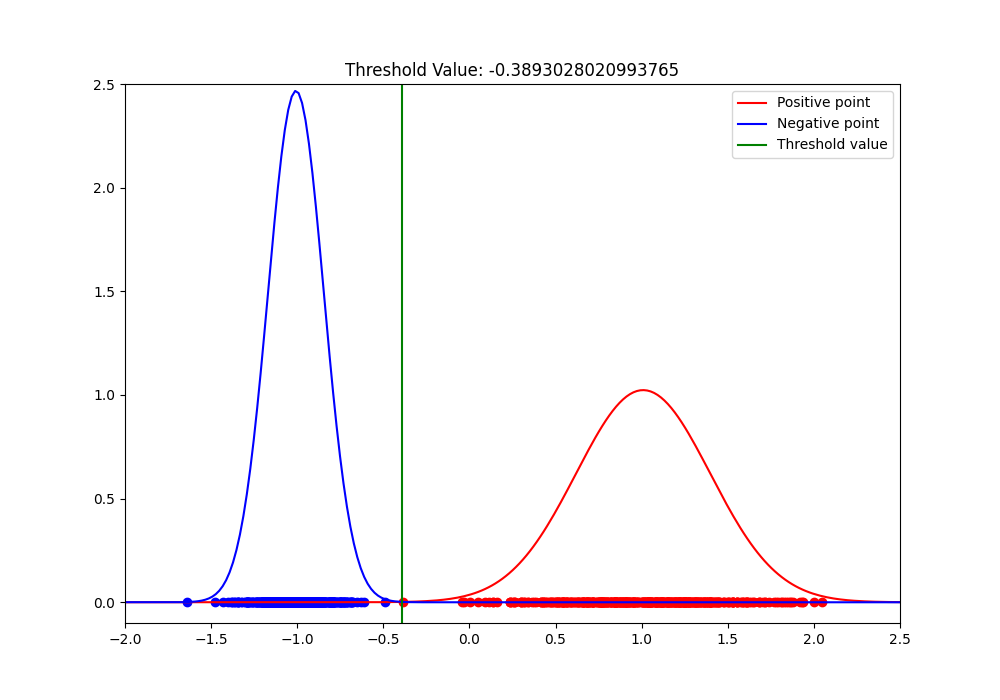

In [14]:
x = np.linspace(-5, 5, 500)
ptemp = np.zeros((len(project_pos), 1))
ntemp = np.zeros((len(project_neg), 1))

plt.figure(figsize = (10,7))
plt.title(f'Threshold Value: {result}')
plt.plot(x, norm.pdf(x, positive_mean, positive_std), color = 'red', label = 'Positive point')
plt.plot(x, norm.pdf(x, negative_mean, negative_std), color = 'blue', label = 'Negative point')

plt.scatter(project_pos, ptemp, color = 'red')
plt.scatter(project_neg, ntemp ,color = 'blue')

yp = np.linspace(-0.1, 0.1, 1000)
xp = result * np.ones((1000))
plt.plot(xp, yp*1000, color = 'green', label = 'Threshold value')
plt.ylim(-0.1, 2.5)
plt.xlim(-2, 2.5)
plt.legend();

### Showing the hyperplane

<IPython.core.display.Javascript object>


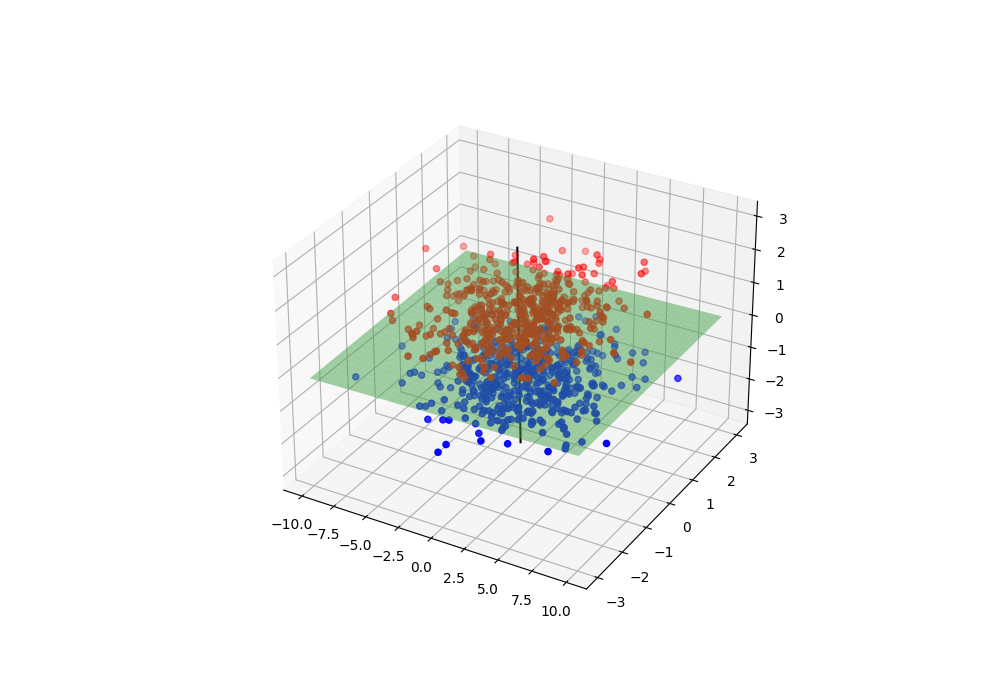

The equation of hyperplane is -0.006556858371172118x + -0.01823739128274949y + 0.9998121849465029z = 0


In [15]:
fig = plt.figure(figsize=(10,7)) 
ax = plt.axes(projection = '3d') 

x = np.linspace(-10, 10, 100)
y = np.linspace(-3, 3, 30)

X, Y = np.meshgrid(x, y)
Z = (w[0, 0]*X + w[1, 0]*Y) / (-w[2, 0])
print(f'The equation of hyperplane is {w[0, 0]}x + {w[1, 0]}y + {w[2, 0]}z = 0')

ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, alpha=0.5, color= '#56d160')

x = [-3*w[0, 0], 3*w[0, 0]]
y = [-3*w[1, 0], 3*w[1, 0]]
z = [-3*w[2, 0], 3*w[2, 0]]
ax.plot3D(x, y, z, color='black')

ax.scatter(pos_points.iloc[:, 0], pos_points.iloc[:, 1], pos_points.iloc[:, 2], color = 'r')
ax.scatter(neg_points.iloc[:, 0], neg_points.iloc[:, 1], neg_points.iloc[:, 2], color = 'b')

plt.show()

### Projecting the points to the line

In [16]:
w = w.reshape((-1, 1))
m = np.linalg.norm(w)**2
class_0_proj = w * w.T.dot(np.transpose(neg_points))/m
class_0_proj = class_0_proj.T
class_0_proj.shape

(500, 3)

In [17]:
class_1_proj = w * w.T.dot(np.transpose(pos_points))/m
class_1_proj = class_1_proj.T
class_1_proj.shape

(500, 3)

<IPython.core.display.Javascript object>


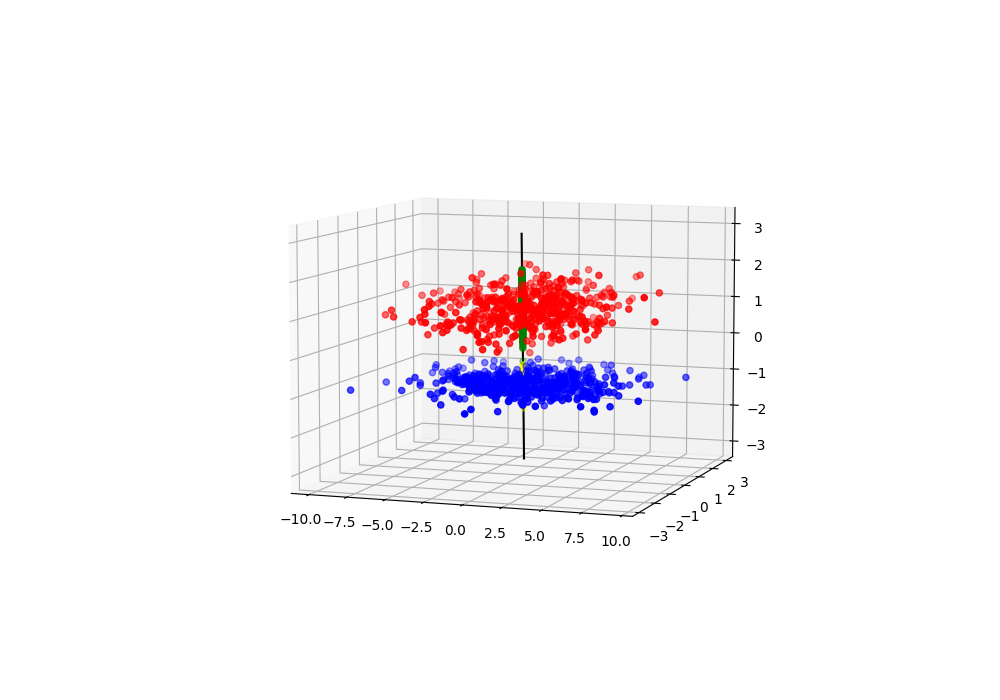

In [18]:
plt.figure(figsize=(10, 7))
ax = plt.axes(projection='3d')
ax.plot3D(x, y, z, color='black')
ax.scatter(class_0_proj[:, 0], class_0_proj[:, 1], class_0_proj[:, 2], color='yellow')
ax.scatter(class_1_proj[:, 0], class_1_proj[:, 1], class_1_proj[:, 2], color='green')
ax.scatter(pos_points.iloc[:, 0], pos_points.iloc[:, 1], pos_points.iloc[:, 2], color = 'r')
ax.scatter(neg_points.iloc[:, 0], neg_points.iloc[:, 1], neg_points.iloc[:, 2], color = 'b');

## Testing the model

In [19]:
pred_pos_dataset = pd.DataFrame(project_pos)
pred_neg_dataset = pd.DataFrame(project_neg)

pred_pos_dataset = pred_pos_dataset.values
pred_neg_dataset = pred_neg_dataset.values

ptemp = np.zeros((len(pred_pos_dataset), 1))
ntemp = np.zeros((len(pred_neg_dataset), 1))
pred_pos = np.append(pred_pos_dataset, ptemp, axis=1)
pred_neg = np.append(pred_neg_dataset, ntemp, axis=1)

tp=0
tn=0
fp=0
fn=0
for i in range(len(pred_pos_dataset)):
  if pred_pos[i, 0] < result:
    pred_pos[i, 1] = 0
    fn+=1
  else:
    pred_pos[i, 1] = 1
    tp+=1

for i in range(len(pred_neg_dataset)):
  if pred_neg[i, 0] < result:
    pred_neg[i, 1] = 0
    tn+=1
  else:
    pred_neg[i, 1] = 1
    fp+=1

accuracy = (tp+tn)/(tp+tn+fp+fn)
print(f'Accuracy of the model with training data is {accuracy * 100}')

Accuracy of the model with training data is 100.0
